In [88]:
import numpy as np
from scipy import linalg
A = np.random.randn(10,15)
m, n = A.shape
print(A)
x = np.zeros(n)
x[:3] = [1.1,1.2,1.3]
print(x)
b = A.dot(x)
print(b)

[[ -1.57187564e+00   5.87132899e-01   5.34025563e-02  -1.03262938e+00
    1.22702496e+00   1.35859443e-01   1.78724297e+00   4.92126461e-01
    3.14673271e-01  -8.79055963e-01  -3.75782891e-01   4.11946142e-01
   -7.54006768e-01  -1.56484354e+00  -1.07411712e+00]
 [  1.34074651e+00  -3.37783969e-01   1.88692014e+00   7.25791830e-01
   -6.15144026e-01  -1.67265228e+00   1.74614310e+00   8.38639227e-01
   -1.46783555e+00  -2.46458520e-03  -5.83490551e-01  -1.58288560e-01
    1.04654481e+00   1.66183872e-01  -2.64882078e-01]
 [ -6.76732670e-01  -1.94172179e+00  -4.42885401e-01  -7.44081465e-01
   -6.50761760e-01  -2.59251615e+00  -5.21740395e-01   3.17586404e-01
   -3.77536747e-01  -1.70980419e-01  -2.06287881e-01  -1.55645498e-01
   -9.64112636e-02   1.01810334e+00   4.76501564e-01]
 [ -1.08863495e+00  -9.76084902e-01  -7.17468095e-01  -9.59997415e-01
   -3.58459293e-01   1.25171443e+00  -6.22922214e-01  -2.07672226e+00
    2.06076231e+00   1.93312131e+00   1.76285490e+00   1.90171803e-0

In [193]:
# Orthogonal matching pursuit (OMP)
def OMP(A, b, tol=1e-5, maxnnz=np.inf):
    m, n = A.shape
    supp = []
    x = np.zeros(n)
    r = b.copy()
    while len(supp) < maxnnz and linalg.norm(r) > tol:
        s = np.argmax(np.abs( A.T.dot(r) ))
        supp.append(s)
        Asupp = A[:,supp]
        x[supp] = linalg.lstsq(Asupp, b)[0]
        r = b - Asupp.dot(x[supp])
    return x

In [123]:
print(OMP(A,b,maxnnz=5))
%timeit OMP(A,b,maxnnz=5)


[ 1.1  1.2  1.3  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
1000 loops, best of 3: 526 µs per loop


In [127]:
supp = []
z = []
r = b.copy()
s = np.argmax(np.abs( A.T.dot(r) ))
supp.append(s)
print(s)
#Q, R = linalg.qr_insert(np.empty((m,0)),np.empty((0,0)),A[:,s],Q.shape[1],which='col')
R = np.atleast_2d(linalg.norm(A[:,s]))
Q = np.atleast_2d(A[:,s] / R).T
zi = Q[:,0].dot(b)
z.append(zi)
r -= zi*Q[:,0]
print(Q.shape, R.shape)
print(Q)
print(R)
print(linalg.norm(r))

1
(10, 1) (1, 1)
[[ 0.17019482]
 [-0.09791494]
 [-0.56285551]
 [-0.28294206]
 [-0.19697845]
 [ 0.31989883]
 [ 0.00298995]
 [ 0.52024405]
 [ 0.14208206]
 [ 0.36414003]]
[[ 3.44976952]]
5.090547312217371


In [129]:
s = np.argmax(np.abs( A.T.dot(r) ))
supp.append(s)
print(s)
Q, R = linalg.qr_insert(Q,R,A[:,s],Q.shape[1],which='col')
zi = Q[:,-1].dot(b)
z.append(zi)
r -= zi*Q[:,-1]
print(Q.shape, R.shape)
print(Q)
print(R)
print(linalg.norm(r))

2
(10, 3) (3, 3)
[[ 0.17019482 -0.39132082 -0.10009993]
 [-0.09791494  0.34278841  0.74539389]
 [-0.56285551 -0.28973135 -0.02329284]
 [-0.28294206 -0.34741977 -0.21749584]
 [-0.19697845  0.22624455 -0.11367282]
 [ 0.31989883 -0.2046034   0.31395438]
 [ 0.00298995  0.16241219 -0.27188366]
 [ 0.52024405 -0.32954491  0.08272049]
 [ 0.14208206 -0.30816766  0.06415145]
 [ 0.36414003  0.44913845 -0.43606568]]
[[ 3.44976952 -0.70706527  0.91198113]
 [ 0.          3.70932682 -0.47374128]
 [ 0.          0.          2.86910017]]
1.1541114112329936e-15


In [132]:
def spvec(n, nz):
    v = np.zeros(n)
    v[nz[1]] = nz[0] #np.array(nz[0]).ravel()
    return v

In [133]:
xest = spvec(n, (linalg.solve_triangular(R, z), supp))
print(xest)

[ 1.1  1.2  1.3  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]


In [194]:
# Orthogonal matching pursuit with QR factorization (OMPqr)
def OMPqr(A, b, tol=1e-5, maxnnz=np.inf):
    m, n = A.shape
    supp = []
    xnz = []
    r = b.copy()

    # find the 1st atom and orthonormal basis
    s = np.argmax(np.abs( A.T.dot(r) ))
    supp.append(s)
    R = np.atleast_2d(linalg.norm(A[:,s]))
    Q = np.atleast_2d(A[:,s] / R).T
    xi = Q[:,-1].dot(b)
    xnz.append(xi)
    r -= xi * Q[:,-1]

    while len(supp) < maxnnz and linalg.norm(r) > tol:
        s = np.argmax(np.abs( A.T.dot(r) ))
        supp.append(s)
        Q, R = linalg.qr_insert(Q, R, A[:,s], Q.shape[1], which='col')
        xi = Q[:,-1].dot(b)
        xnz.append(xi)
        r -= xi * Q[:,-1]

    xnz = linalg.solve_triangular(R, xnz)
    x = np.zeros(n)
    x[supp] = xnz
    return x

In [135]:
print(OMPqr(A,b,maxnnz=5))
%timeit OMPqr(A,b,maxnnz=5)


[ 1.1  1.2  1.3  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
The slowest run took 4.54 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 254 µs per loop


In [195]:
# Generalized orthogonal matching pursuit with QR factorization (gOMPqr)
def gOMPqr(A, b, N=3, tol=1e-5, maxnnz=np.inf):
    m, n = A.shape
    supp = []
    xnz = []
    r = b.copy()

    # find the 1st atom group and orthonormal basis
    s = np.argsort(-np.abs(A.T.dot(r)))
    supp.extend(s[:N])
    Q, R = linalg.qr(A[:,s[:N]], mode='economic')
    xi = Q.T.dot(b)
    xnz.extend(xi)
    r -= Q.dot(xi)
    
    while len(supp) < maxnnz and linalg.norm(r) > tol:
        s = np.argsort(-np.abs(A.T.dot(r)))
        supp.extend(s[:N])
        Q, R = linalg.qr_insert(Q, R, A[:,s[:N]], Q.shape[1], which='col')
        xi = Q[:,-N:].T.dot(b)
        xnz.extend(xi)
        r -= Q[:,-N:].dot(xi)

    xnz = linalg.solve_triangular(R, xnz)
    x = np.zeros(n)
    x[supp] = xnz
    return x

In [187]:
cl = []
cl.extend([1.1])
print(cl)

[1.1]


In [196]:
# OMP
print("Running OMP..")
t0 = time()
#x_est = OMP(A, b, maxnnz=100)
x_est = OMP(A, b, tol=tol)
print('done in %.2fs.' % (time() - t0))

Tpred = np.nonzero(x_est)[0]
print('Predicted supprt of %d nonzeros = ' % (np.count_nonzero(x_est)))
print(Tpred)

from sklearn import metrics
print(metrics.classification_report(x_true == 0, x_est == 0))
print(metrics.confusion_matrix(x_true == 0, x_est == 0))

Running OMP..
done in 11.07s.
Predicted supprt of 406 nonzeros = 
[   8   40   63   65   73  102  117  130  132  134  136  151  161  167  169
  175  178  182  185  188  189  195  204  209  212  229  237  241  246  254
  265  294  301  303  308  315  316  319  324  329  334  338  347  349  353
  374  392  397  400  408  412  420  434  447  448  449  451  463  474  482
  484  486  493  503  516  524  528  538  543  559  565  575  582  585  586
  590  596  601  605  616  642  646  650  651  654  663  664  668  669  682
  694  695  704  705  708  716  727  736  742  745  746  749  750  766  767
  793  805  810  830  838  846  848  859  879  884  898  901  911  912  916
  920  925  942  944  948  970  975  984  985  991 1004 1006 1044 1059 1066
 1085 1091 1115 1119 1124 1138 1140 1144 1161 1171 1175 1176 1219 1228 1242
 1246 1270 1288 1295 1309 1315 1324 1326 1341 1347 1348 1356 1367 1372 1383
 1387 1403 1412 1425 1453 1461 1467 1471 1477 1478 1482 1485 1487 1493 1499
 1545 1547 1569 1576 1

In [168]:
from time import time
# Generate sythetic data for demo
rng = np.random.RandomState(int(time()))
#m, n = 512, 2048
#m, n = 1024, 8192
m, n = 2000, 4000

# use a random matrix as a basis (design matrix)
A = rng.randn(m, n) / np.sqrt(m)

# generate a k-sparse Gaussian signal vector
k = 500
stdx = 1.
snr = 10.

x_true = np.zeros(n)
T = np.sort(rng.choice(n,k,replace=False))
print('True support of %d nonzeros = ' % (k))
print(T)
x_true[T] = rng.randn(k) * stdx

# make the query vector
b = A.dot(x_true)

# add noise
normb = linalg.norm(b)
noise = rng.randn(m)
noise = noise / linalg.norm(noise) * normb / snr
tol = linalg.norm(noise)
b = b + noise

True support of 500 nonzeros = 
[   8   15   40   51   63   65   69   73  102  117  130  132  134  136  151
  161  167  169  175  178  181  182  185  188  189  195  204  209  212  228
  229  237  241  246  250  254  265  294  301  303  308  310  315  316  319
  321  324  329  334  338  347  349  353  354  372  374  392  397  400  408
  412  416  420  434  436  447  448  449  451  463  474  479  482  484  486
  493  503  515  516  524  528  538  543  551  559  564  565  573  575  582
  585  586  590  596  601  605  616  627  646  650  651  654  663  664  668
  669  682  695  703  704  705  708  711  716  727  736  742  745  746  747
  749  750  751  766  767  793  795  804  805  810  830  838  846  848  859
  877  879  880  884  895  898  901  911  912  916  920  925  942  944  948
  953  955  970  975  984  985  991  994 1004 1006 1028 1044 1059 1066 1085
 1091 1114 1115 1119 1124 1134 1138 1140 1144 1161 1171 1175 1176 1219 1228
 1233 1242 1246 1265 1270 1288 1295 1309 1315 1317 1324 

In [174]:
# OMP
print("Running OMP..")
t0 = time()
#x_est = OMP(A, b, maxnnz=100)
x_est = OMP(A, b, tol=tol)
print('done in %.2fs.' % (time() - t0))

Tpred = np.nonzero(x_est)[0]
print('Predicted supprt of %d nonzeros = ' % (np.count_nonzero(x_est)))
print(Tpred)

from sklearn import metrics
print(metrics.classification_report(x_true == 0, x_est == 0))
print(metrics.confusion_matrix(x_true == 0, x_est == 0))

Running OMP..
done in 11.03s.
Predicted supprt of 406 nonzeros = 
[   8   40   63   65   73  102  117  130  132  134  136  151  161  167  169
  175  178  182  185  188  189  195  204  209  212  229  237  241  246  254
  265  294  301  303  308  315  316  319  324  329  334  338  347  349  353
  374  392  397  400  408  412  420  434  447  448  449  451  463  474  482
  484  486  493  503  516  524  528  538  543  559  565  575  582  585  586
  590  596  601  605  616  642  646  650  651  654  663  664  668  669  682
  694  695  704  705  708  716  727  736  742  745  746  749  750  766  767
  793  805  810  830  838  846  848  859  879  884  898  901  911  912  916
  920  925  942  944  948  970  975  984  985  991 1004 1006 1044 1059 1066
 1085 1091 1115 1119 1124 1138 1140 1144 1161 1171 1175 1176 1219 1228 1242
 1246 1270 1288 1295 1309 1315 1324 1326 1341 1347 1348 1356 1367 1372 1383
 1387 1403 1412 1425 1453 1461 1467 1471 1477 1478 1482 1485 1487 1493 1499
 1545 1547 1569 1576 1

In [200]:
# OMPqr
print("Running OMPqr..")
t0 = time()
x_est = OMPqr(A, b, tol=tol)
print('done in %.2fs.' % (time() - t0))

Tpred = np.nonzero(x_est)[0]
print('Predicted supprt of %d nonzeros = ' % (np.count_nonzero(x_est)))
print(Tpred)

from sklearn import metrics
print(metrics.classification_report(x_true == 0, x_est == 0))
print(metrics.confusion_matrix(x_true == 0, x_est == 0))

Running OMPqr..
done in 2.24s.
Predicted supprt of 406 nonzeros = 
[   8   40   63   65   73  102  117  130  132  134  136  151  161  167  169
  175  178  182  185  188  189  195  204  209  212  229  237  241  246  254
  265  294  301  303  308  315  316  319  324  329  334  338  347  349  353
  374  392  397  400  408  412  420  434  447  448  449  451  463  474  482
  484  486  493  503  516  524  528  538  543  559  565  575  582  585  586
  590  596  601  605  616  642  646  650  651  654  663  664  668  669  682
  694  695  704  705  708  716  727  736  742  745  746  749  750  766  767
  793  805  810  830  838  846  848  859  879  884  898  901  911  912  916
  920  925  942  944  948  970  975  984  985  991 1004 1006 1044 1059 1066
 1085 1091 1115 1119 1124 1138 1140 1144 1161 1171 1175 1176 1219 1228 1242
 1246 1270 1288 1295 1309 1315 1324 1326 1341 1347 1348 1356 1367 1372 1383
 1387 1403 1412 1425 1453 1461 1467 1471 1477 1478 1482 1485 1487 1493 1499
 1545 1547 1569 1576 

In [212]:
# gOMPqr
print("Running gOMPqr..")
t0 = time()
x_est = gOMPqr(A, b, N=6,tol=tol)
print('done in %.2fs.' % (time() - t0))

Tpred = np.nonzero(x_est)[0]
print('Predicted supprt of %d nonzeros = ' % (np.count_nonzero(x_est)))
print(Tpred)

from sklearn import metrics
print(metrics.classification_report(x_true == 0, x_est == 0))
print(metrics.confusion_matrix(x_true == 0, x_est == 0))

Running gOMPqr..
done in 0.48s.
Predicted supprt of 414 nonzeros = 
[   8   40   63   65   73  102  117  130  132  134  136  151  161  167  169
  175  178  182  185  188  189  195  204  209  212  228  229  237  241  246
  250  254  265  294  301  303  308  315  316  319  324  329  334  338  347
  349  353  374  392  397  400  408  412  420  434  447  448  449  451  463
  474  482  484  486  493  503  516  524  528  538  543  559  565  575  582
  585  586  590  596  601  605  616  642  646  650  651  654  663  664  668
  669  682  695  704  705  708  716  727  736  742  745  746  749  750  766
  767  793  805  810  830  838  846  848  859  879  884  898  901  911  912
  916  920  923  925  942  944  948  955  970  975  984  985  991 1004 1006
 1044 1059 1066 1085 1091 1115 1119 1124 1138 1140 1144 1159 1161 1171 1175
 1176 1219 1228 1242 1246 1270 1288 1295 1309 1315 1324 1326 1341 1347 1348
 1356 1367 1372 1383 1387 1403 1412 1425 1453 1461 1467 1471 1477 1478 1482
 1485 1487 1493 1499

rel. error = 8.81e-02


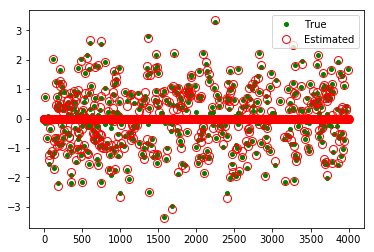

In [213]:
print('rel. error = %.2e' % (linalg.norm(x_est-x_true)/linalg.norm(x_true)))
import matplotlib.pyplot as plt
plt.figure()
plt.plot(np.arange(n), x_true, 'g.', markersize=8, mec='green', label='True')
plt.plot(np.arange(n), x_est, 'ro', mfc = 'None', markersize=8, mec='red', mew=1, label='Estimated')
plt.legend(loc='upper right', shadow=False)
plt.show()